In [1]:
import torch
from IPython import display
import torchvision
from torch.utils import data
from torchvision import transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt

In [2]:
#  整合以上组件
def get_dataloader_workers():
    # 多个进程同步读取数据集
    return 2
def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data/", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data/", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [3]:
# 测试上述函数
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break
next(iter(train_iter))[1]

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


tensor([2, 0, 9, 3, 1, 0, 1, 1, 5, 8, 3, 7, 6, 7, 0, 9, 0, 7, 5, 0, 1, 1, 9, 8,
        8, 2, 0, 5, 2, 4, 4, 4])

In [39]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [35]:
# 初始化模型参数
num_inputs = 784
num_outputs = 10
W = torch.normal(0, 0.01, size=(num_inputs,num_outputs), requires_grad = True)
b = torch.zeros(num_outputs, requires_grad=True)

In [10]:
# 定义 softmax
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp/partition

In [13]:
# 测试 softmax 函数
X = torch.normal(0,1, (2,5))
X_prob = softmax(X)
X,X_prob, X_prob.sum(1,keepdim=True)

(tensor([[ 0.2817, -1.0501,  0.9448,  0.2744,  0.2450],
         [-0.7328, -0.2606,  0.2876, -1.6097, -0.2181]]),
 tensor([[0.1937, 0.0511, 0.3760, 0.1923, 0.1868],
         [0.1339, 0.2148, 0.3715, 0.0557, 0.2241]]),
 tensor([[1.0000],
         [1.0000]]))

In [43]:
# 定义回归模型
def net(X):
    return softmax(torch.matmul(X.reshape(-1, W.shape[0]),W) + b)

In [16]:
# 定义交叉熵损失函数
def cross_entropy(y_hat, y):
    # 由于真实 y 是"类别索引"，故交叉熵（-SUM(y*log(y_hat))）可简化如下：即取对应分类的预测概率
    return -torch.log(y_hat[range(len(y_hat)), y])

# 测试函数功能
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
cross_entropy(y_hat,y)

tensor([2.3026, 0.6931])

In [21]:
def accuracy(y_hat, y):
    '''计算预测正确的数量'''
    if len(y_hat.shape)>1 and y_hat.shape[1]>1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype)==y 
    return float(cmp.type(y.dtype).sum())

# accuracy(y_hat, y) / len(y)

In [22]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [24]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [53]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
#         d2l.use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        
#         self.config_axes = lambda: set_axes(
#             self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
#         self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [26]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [48]:
# 定义优化算法
def sgd(params,lr,batch_size):
    '''小批量样本随机梯度下降'''
    with torch.no_grad():
        for param in params:
            param-=lr*param.grad/batch_size
            param.grad.zero_()

In [49]:
lr = 0.1

def updater(batch_size):
    return sgd([W, b], lr, batch_size)

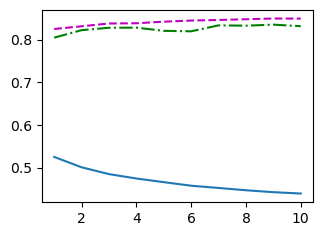

In [54]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

In [55]:
# 返回fashion-mnist数据集的文本标签
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','ankle boot']
    return [text_labels[int (i)] for i in labels]

In [57]:
# 画数据集图
def show_images(imgs,num_rows,num_cols,titles=None,scale=1.5):
    figsize= (num_cols*scale,num_rows*scale) # figsize是长*宽的模式
    _,axes=plt.subplots(num_rows,num_cols,figsize=figsize)
    axes=axes.flatten()
    for i,(ax,img) in enumerate(zip(axes,imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL 图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

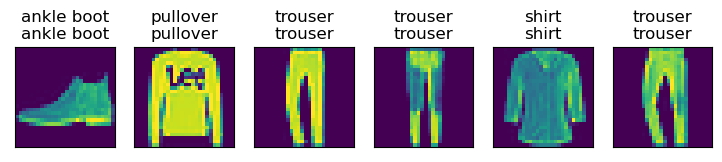

In [58]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)